In [1]:
!pip install xgboost

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 수질 데이터
데이터 출처 : https://www.kaggle.com/datasets/adityakadiwal/water-potability?datasetId=1292407&sortBy=voteCount

In [3]:
# 데이터 로드
water = pd.read_csv('water_potability.csv')

In [4]:
# 데이터 확인
water.head()
# ph : 산성도. WHO 기준 6.5~8.5가 적당
# hardness : Calcium과 Magnesium으로부터 생기는 특성. 
#            물이 흘러내려오면서 칼슘과 마그네슘을 녹여 물 안에 축적
# Solids : 총용존 고형물. 500mg/L가 권고 농도이고 1000mg/L가 최대 허용 농도
# Chloramine : 클로라민. 4mg/L가 최대 농도
# Sulfate : 황. 자연적으로 생긴다.
# Conductivity : 전기 전도도
# Organic_carbon : 2mg/L 미만이 식수로 적당
# Trihalomethanes : THMs. Chlorine을 처리한 물에서 발견됨. 80ppm이하가 식수로 적당
# Turbidity : 부유물의 양. 최대 허용 범위는 기준에 따라 0.98이기도 하고 5.00이기도 하다.
# Potability : 식수로 적당한지 여부. 1이 적당, 0이 적당하지 않음.

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## 변수들 간의 상관계수 확인

In [5]:
# 상관계수 확인
corr = water[water.columns[:-1]].corr()

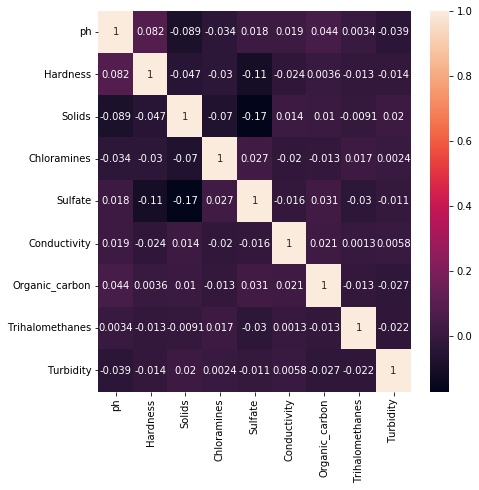

In [6]:
# 상관계수 그래프로 확인
plt.figure(figsize=(7,7))
sns.heatmap(corr, annot=True)
plt.show()

## 결측치 제거

In [7]:
# 결측치 제거
water_dropna = water.dropna()

In [8]:
# 제거된 데이터프레임 확인
water_dropna.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


In [9]:
water.shape, water_dropna.shape

((3276, 10), (2011, 10))

# 클래스별 비율 확인

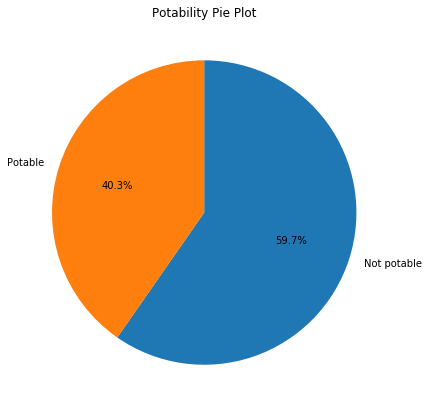

In [10]:
# 클래스별 비율 확인
plt.figure(figsize=(7,7))
plt.title("Potability Pie Plot")
plt.pie([(water_dropna['Potability']==0).sum(), (water_dropna['Potability']==1).sum()],
        labels=["Not potable", "Potable"],
        autopct='%.1f%%',
        startangle=90,
        counterclock=False
       )
plt.show()

In [11]:
# 인덱스 추출
not_potable = water_dropna['Potability']==0
yes_potable = water_dropna['Potability']==1

## 모델 학습을 통한 예측 결과 도출

In [12]:
# 패키지 모듈 호출
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [13]:
# 학습 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
                                                    water_dropna[water_dropna.columns[:-1]],
                                                    water_dropna[water_dropna.columns[-1]],
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

In [14]:
# 모델 학습
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
# 예측
pred = model.predict(X_test)

In [16]:
from metrics import metrics

In [17]:
# 결과 도출
metrics(pred, y_test.tolist())

Overall metrics
Accuracy   : 0.645
Recall     : 0.488
Specifcity : 0.762
Precision  : 0.604
F1 Score   : 0.540


## 다양한 모델 시도 및 결과 도출

In [18]:
# 모델들 호출
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [19]:
# 모델들을 딕셔너리 형태로 저장
models = {
          "XGBoost": XGBClassifier,
          'Random Forest': RandomForestClassifier,
          "Gradient Boosting": GradientBoostingClassifier,
          "LightGBM": lgb.LGBMClassifier
}

In [20]:
# 각 모델에 대해서 학습 및 결과 도출
for m in models.keys():
    mod = models[m]()
    mod.fit(X_train, y_train)
    pred = mod.predict(X_test)
    print(f"[*] Accuracy for model {m} :")
    metrics(pred, y_test.tolist())

[*] Accuracy for model XGBoost :
Overall metrics
Accuracy   : 0.625
Recall     : 0.483
Specifcity : 0.732
Precision  : 0.572
F1 Score   : 0.524
[*] Accuracy for model Random Forest :
Overall metrics
Accuracy   : 0.623
Recall     : 0.390
Specifcity : 0.797
Precision  : 0.588
F1 Score   : 0.469
[*] Accuracy for model Gradient Boosting :
Overall metrics
Accuracy   : 0.645
Recall     : 0.355
Specifcity : 0.861
Precision  : 0.656
F1 Score   : 0.460
[*] Accuracy for model LightGBM :
Overall metrics
Accuracy   : 0.645
Recall     : 0.488
Specifcity : 0.762
Precision  : 0.604
F1 Score   : 0.540


## Grid Search

![GridSearch](gridsearch.png)  

## Grid Search를 통한 하이퍼파리미터 서치 및 성능 최적화

In [21]:
# 모듈 호출
from sklearn.model_selection import GridSearchCV

In [22]:
# Grid Search를 할 변수들 생성
bagging_fractions = [i/5 for i in range(1,5)] # iteration마다 데이터의 일부를 선택하는 비율
bagging_freqs = [i*20 for i in range(1,5)] # iteration마다 bagging frequency를 지정
learning_rates = [0.01, 0.003, 0.001, 0.0003]
num_leaves = [10 * i for i in range(1, 6)]

In [23]:
# 파라미터들 저장
params = {
            'bagging_fraction':bagging_fractions,
            'bagging_freq':bagging_freqs,
            'learning_rate':learning_rates,
            'num_leaves':num_leaves
         }

In [24]:
# 모델 생성 및 Grid search 클래스 생성
model = lgb.LGBMClassifier(seed=42)
clf = GridSearchCV(model, params, scoring='accuracy', cv=2, return_train_score=True)

In [25]:
# GridSearchCV로 학습
clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current val

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, seed=42, silent='warn',
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'bagging_fraction': [0.2, 0.4, 0.6, 0.8],
      

In [26]:
# 최고 성능을 내는 변수들
clf.best_params_

{'bagging_fraction': 0.6,
 'bagging_freq': 20,
 'learning_rate': 0.01,
 'num_leaves': 20}

In [27]:
# 최고 성능
clf.best_score_

0.6604477611940298

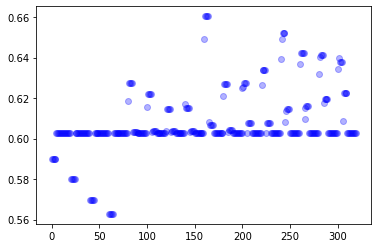

In [28]:
# Test set 성능 시각화
plt.plot(clf.cv_results_['mean_test_score'], 'bo', alpha=0.3)
plt.show()

## 데이터 디버깅

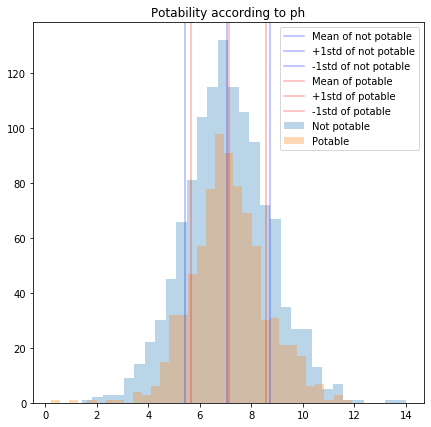

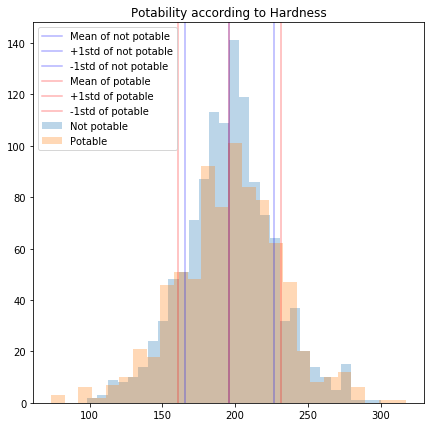

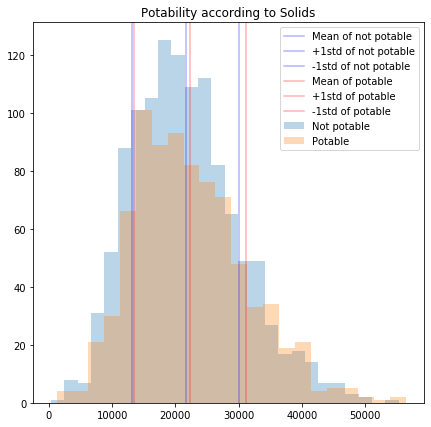

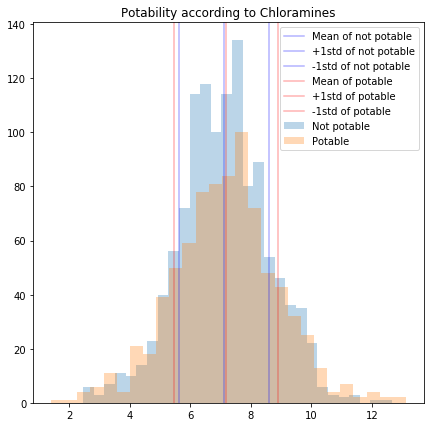

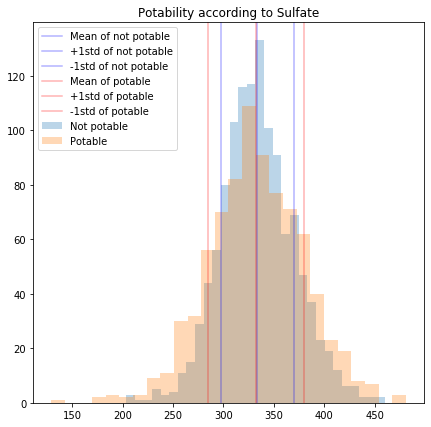

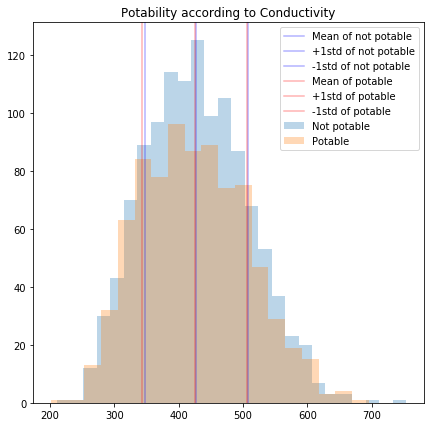

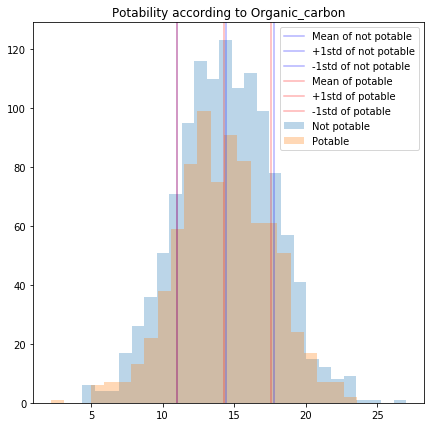

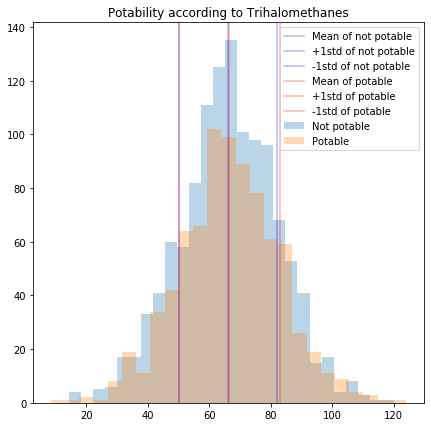

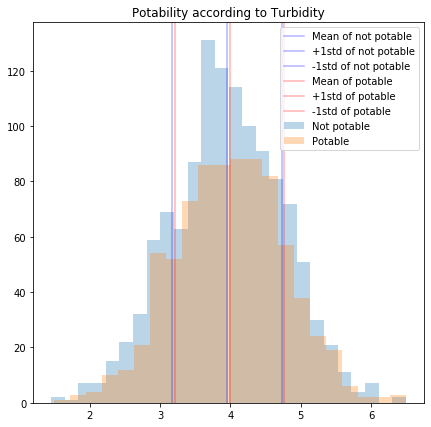

In [34]:
# 두 클래스 간의 데이터 분포 overlay
for c in water_dropna.columns[:-1]:
    plt.figure(figsize=(7,7))
    plt.title(f"Potability according to {c}")
    plt.hist(water_dropna[not_potable][c], bins='auto', alpha=0.3, label='Not potable')
    plt.axvline(water_dropna[not_potable][c].mean(), color='b', alpha=0.3, label='Mean of not potable')
    plt.axvline(water_dropna[not_potable][c].mean() + water_dropna[not_potable][c].std(), 
                color='b', alpha=0.3, label='+1std of not potable')
    plt.axvline(water_dropna[not_potable][c].mean() - water_dropna[not_potable][c].std(), 
                color='b', alpha=0.3, label='-1std of not potable')
    plt.hist(water_dropna[yes_potable][c], bins='auto', alpha=0.3, label='Potable')
    plt.axvline(water_dropna[yes_potable][c].mean(), color='r', alpha=0.3, label='Mean of potable')
    plt.axvline(water_dropna[yes_potable][c].mean() + water_dropna[yes_potable][c].std(), 
                color='r', alpha=0.3, label='+1std of potable')
    plt.axvline(water_dropna[yes_potable][c].mean() - water_dropna[yes_potable][c].std(), 
                color='r', alpha=0.3, label='-1std of potable')
    plt.legend()
    plt.show()

## 통계적 분석

In [30]:
# 통계 패키지 분석
from scipy.stats import ttest_ind

In [31]:
# 통계 분석
for c in water_dropna.columns[:-1]:
    res_equivar = ttest_ind(water_dropna[not_potable][c], water_dropna[yes_potable][c])
    res_not_equivar = ttest_ind(water_dropna[not_potable][c], water_dropna[yes_potable][c])
    inequal1 = '>' if res_equivar[1]>0.05 else '<'
    inequal2 = '>' if res_not_equivar[1]>0.05 else '<'
    significant1 = 'Significant' if inequal1 == '<' else 'NOT Significant'
    significant2 = 'Significant' if inequal2 == '<' else 'NOT Significant'
    print(f"- Variable {c}")
    print(f"[**] T statistic for assuming equivalent variance : {res_equivar[0]}")
    print(f"[**] p-value for assuming equivalent variance : {res_equivar[1]} {inequal1} 0.5 -> {significant1}")
    print(f"[**] T statistic for assuming NOT equivalent variance : {res_not_equivar[0]}")
    print(f"[**] p-value for assuming NOT equivalent variance : {res_not_equivar[1]} {inequal2} 0.5 -> {significant2}")
    print('====')

- Variable ph
[**] T statistic for assuming equivalent variance : -0.6513321851789707
[**] p-value for assuming equivalent variance : 0.5149065707812117 > 0.5 -> NOT Significant
[**] T statistic for assuming NOT equivalent variance : -0.6513321851789707
[**] p-value for assuming NOT equivalent variance : 0.5149065707812117 > 0.5 -> NOT Significant
====
- Variable Hardness
[**] T statistic for assuming equivalent variance : 0.06745790602377671
[**] p-value for assuming equivalent variance : 0.9462238843628967 > 0.5 -> NOT Significant
[**] T statistic for assuming NOT equivalent variance : 0.06745790602377671
[**] p-value for assuming NOT equivalent variance : 0.9462238843628967 > 0.5 -> NOT Significant
====
- Variable Solids
[**] T statistic for assuming equivalent variance : -1.8246028233684708
[**] p-value for assuming equivalent variance : 0.06820943709932177 > 0.5 -> NOT Significant
[**] T statistic for assuming NOT equivalent variance : -1.8246028233684708
[**] p-value for assuming